In [17]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
# get utils for thresholds
from src import util_analysis 
from src import util_process_prolific as util_process
import importlib
from tqdm.auto import tqdm
import multiprocessing as mp

## Load participant data

In [18]:
### 
path_to_human_results = Path('final_results_to_share')

human_thresh_df = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_avg_sex_cond.pdpkl')

N = 33

human_thresh_df_summary = human_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']



### Get actual interaction effect

In [19]:
# reformat array from summary: 
threshold_data = np.zeros((2,3))
threshold_data[0,:] = human_thresh_df_summary.loc[human_thresh_df_summary.azim_delta == 0, 'threshold'].values
threshold_data[1,:] = human_thresh_df_summary.loc[human_thresh_df_summary.elev_delta == 0, 'threshold'].values


# just use vectorized means for above 
interaction_effects = threshold_data \
                      - threshold_data.mean(axis=1, keepdims=True) \
                      - threshold_data.mean(axis=0, keepdims=True) \
                      + threshold_data.ravel().mean()
interaction_effects

overall_interaction = np.power(interaction_effects, 2).sum()
overall_interaction

3.946566365692268

### Prep permutation test

In [20]:
def get_interaction(threshold_data, return_interaction=False):
    """
    Get the overall and unique interaction effects
    for a given threshold data matrix.

    Assumes rows map to elevation and azimuth conditions
    and columns map to the offset size. 

    Parameters
    ----------
    threshold_data : np.ndarray
        A 2D array of threshold data with shape (n_azim_elev, n_offset).
        The rows should be the elevation and azimuth conditions
        and the columns should be the offset size.
    Returns
    -------
    overall_interaction : float
        The overall interaction effect.
    interaction_effects : np.ndarray
        The unique interaction effects for each condition.
        Only returned if return_interaction is True.

    """
    # vectorized means used 
    # first mean is over rows (elevation and azimuth)
    # second mean is over columns (offset size)
    # third mean is over all elements
    interaction_effects = threshold_data \
                        - threshold_data.mean(axis=1, keepdims=True) \
                        - threshold_data.mean(axis=0, keepdims=True) \
                        + threshold_data.mean()
    

    overall_interaction = np.power(interaction_effects, 2).sum()

    if return_interaction:
        return overall_interaction, interaction_effects
    else:
        return overall_interaction


## Permutation test to get null distribution 

Proceedure per bootstrap:
1. permute both offset and azimuth elevation condition per participant
2. Obtain group-average thresholds using permuted data
3. measure interaction 

### Push participant data into n-d array for quick shuffling/manipulation

In [ ]:
human_data = pd.read_csv('final_results_to_share/experiment_6_participant_results.csv')
human_data.head()

,participant,target_azim,target_elev,azim_delta,elev_delta,snr,n_distractors,correct_mean,correct_sem,confusions_mean,confusions_sem,confusions_count
0,participant_001,0,40,0,0,-9,2,0.1875,0.100778,0.1250,0.085391,16
1,participant_001,0,40,0,0,-6,2,0.2500,0.111803,0.1875,0.100778,16
2,participant_001,0,40,0,0,-3,2,0.3125,0.119678,0.2500,0.111803,16
3,participant_001,0,40,0,0,0,2,0.2500,0.111803,0.0625,0.062500,16
4,participant_001,0,40,0,0,3,2,0.7500,0.111803,0.0000,0.000000,16


In [22]:
# break data out of dataframe, into 4D np array, where dim 1 is over participants, dim 2 is over azim and elev, 3 is SNR and 4 is the mean
part_data_for_permute = human_data[['participant', 'azim_delta', 'elev_delta', 'snr', 'correct_mean']].copy()

# get the unique  deltas - same for azimuth and elevation 
deltas = part_data_for_permute.azim_delta.unique() 
n_deltas = len(deltas)
n_participants = part_data_for_permute.participant.nunique()
snrs = part_data_for_permute.snr.unique()
n_snrs = part_data_for_permute.snr.nunique()
offset_dir_conds = 2 
dir_cond_map = {0:'azim_delta', 1:'elev_delta'}

part_data_array = np.zeros((n_participants, offset_dir_conds, n_deltas, n_snrs))

# loop over participants and fill in data array
for part_ix, participant in enumerate(part_data_for_permute.participant.unique()):
    # get the data for this participant
    part_data = part_data_for_permute[part_data_for_permute.participant == participant]
    for dir_ix, cond_str in dir_cond_map.items():
        # get the data for this direction
        if dir_ix == 0:
            alt_cond = dir_cond_map[1]
        elif dir_ix == 1:
            alt_cond = dir_cond_map[0]
        dir_data = part_data[part_data[cond_str].isin(deltas) & (part_data[alt_cond] == 0 )]

        for offset_ix, offset in enumerate(deltas):
            # get the data for this offset
            snr_vals = dir_data[dir_data[cond_str] == offset]
            # fill in the data array
            part_data_array[part_ix, dir_ix, offset_ix, :] = snr_vals.correct_mean.values



### Run permutation test

In [23]:
np.random.seed(0)
rng = np.random.default_rng(0)
n_boots = 10_000  ## use 10_000 for final analysis

N = human_data.participant.nunique()
null_interactions = np.zeros((n_boots))

for i in tqdm(range(n_boots)):
    # shuffle data within participants - vectorized approach 
    shuffled_data = rng.permuted(part_data_array, axis=1)
    shuffled_data = rng.permuted(shuffled_data, axis=2)
    # mean over participants post shuffling 
    shuffled_mean = shuffled_data.mean(axis=0)
    # init_threshold data array for this permutation  
    thresh_data_array = np.zeros((2, 3))
    for dir_cond_ix, cond_str in dir_cond_map.items():
        for offset_ix, offset in enumerate(deltas):
            # get the data for this offset
            snr_vals = shuffled_mean[dir_cond_ix, offset_ix]
            # get threshold for this condition
            thresh, _ = util_analysis.estimate_threshold_poly(snrs, snr_vals, degree=2)
            thresh_data_array[dir_cond_ix, offset_ix] = thresh
    null_interactions[i] = get_interaction(thresh_data_array, return_interaction=False)



  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
## Get p value from null_intarctions and overall interaction

(np.abs(null_interactions) > np.abs(overall_interaction)).mean()

0.0

Text(0.5, 0, 'Interaction statistic')

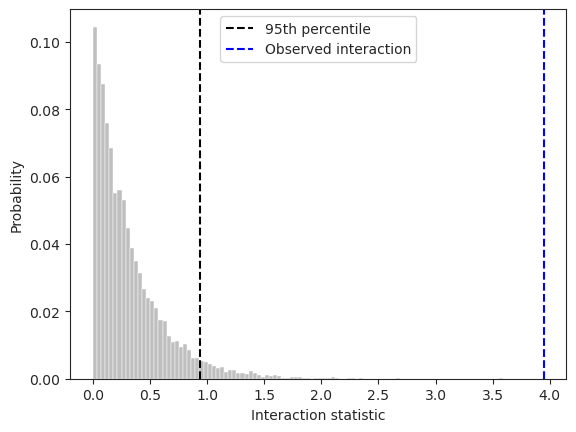

In [25]:
# get 95% percentile from null interactions 

sig_level = np.percentile(null_interactions, 95)

# sns.histplot(data, bins=30, stat='probability')

sns.histplot(null_interactions, bins=100, stat='probability', alpha=0.5, color='gray',);
# add vertical line to plot for actual interaction value 
plt.axvline(sig_level, color='k', linestyle='--', label='95th percentile')
plt.axvline(overall_interaction, color='blue', linestyle='--', label='Observed interaction')
plt.legend()
plt.xlabel('Interaction statistic')
